In [1]:
#!pip install skforecast
# Data processing
# ==============================================================================
import os
import pandas as pd
import numpy as np

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Time series modeling
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold,  OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

import sklearn
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.model_selection import TimeSeriesFold
from skforecast.preprocessing import RollingFeatures

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import Ridge
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import grid_search_forecaster
from scipy.special import inv_boxcox
from skforecast.model_selection import grid_search_forecaster
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

Downloading the dataset

In [2]:
df1 = pd.read_excel('C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/data_final.xlsx')

In [3]:
df = df1.copy()
#drop missing data
df = df.dropna()

In [110]:
#make column datetime to index
df = df.set_index('datetime')
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('fivethirtyeight')

Exploratory data analysis

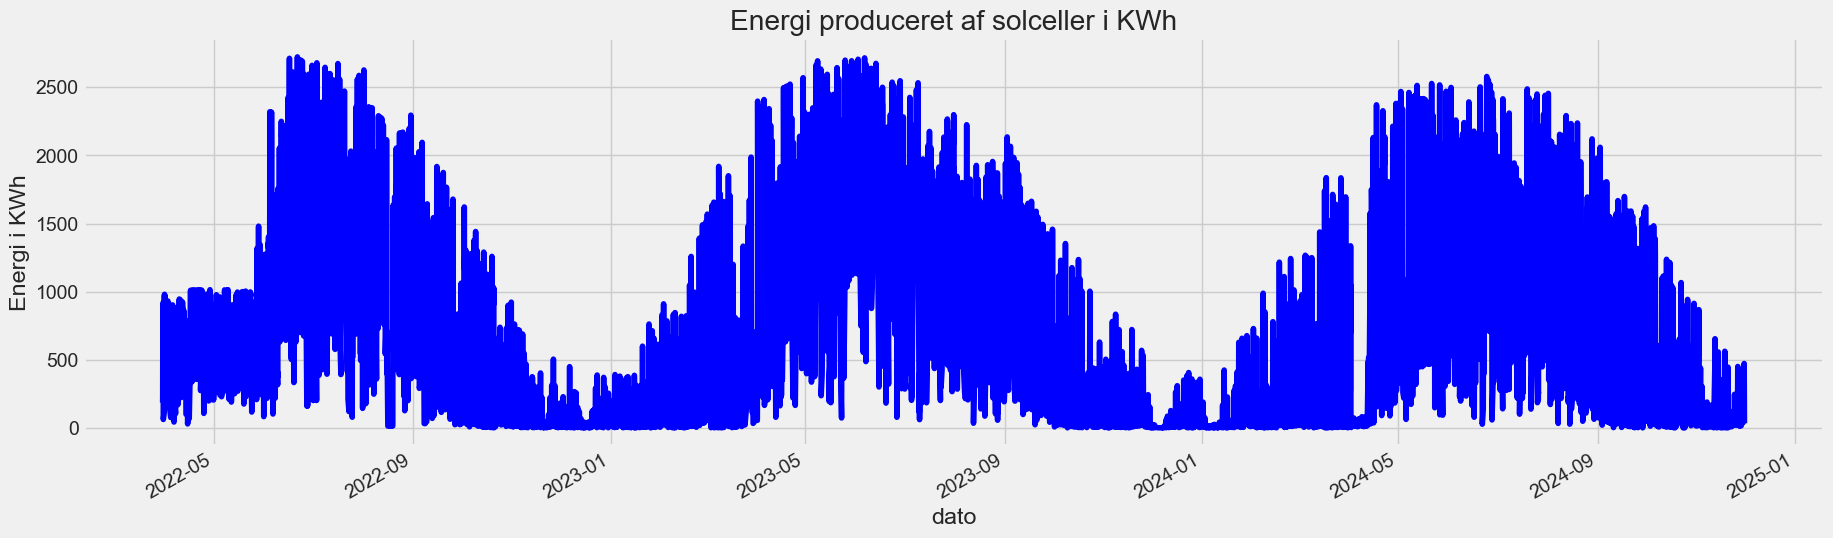

In [18]:
#make column datetime to index
df = df.set_index('datetime')
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('fivethirtyeight')
ax = df['energy_total'].plot(figsize=(20, 6), color='blue')
ax.set_xlabel('dato')
ax.set_ylabel('Energi i KWh')
ax.set_title('Energi produceret af solceller i KWh')
plt.show()

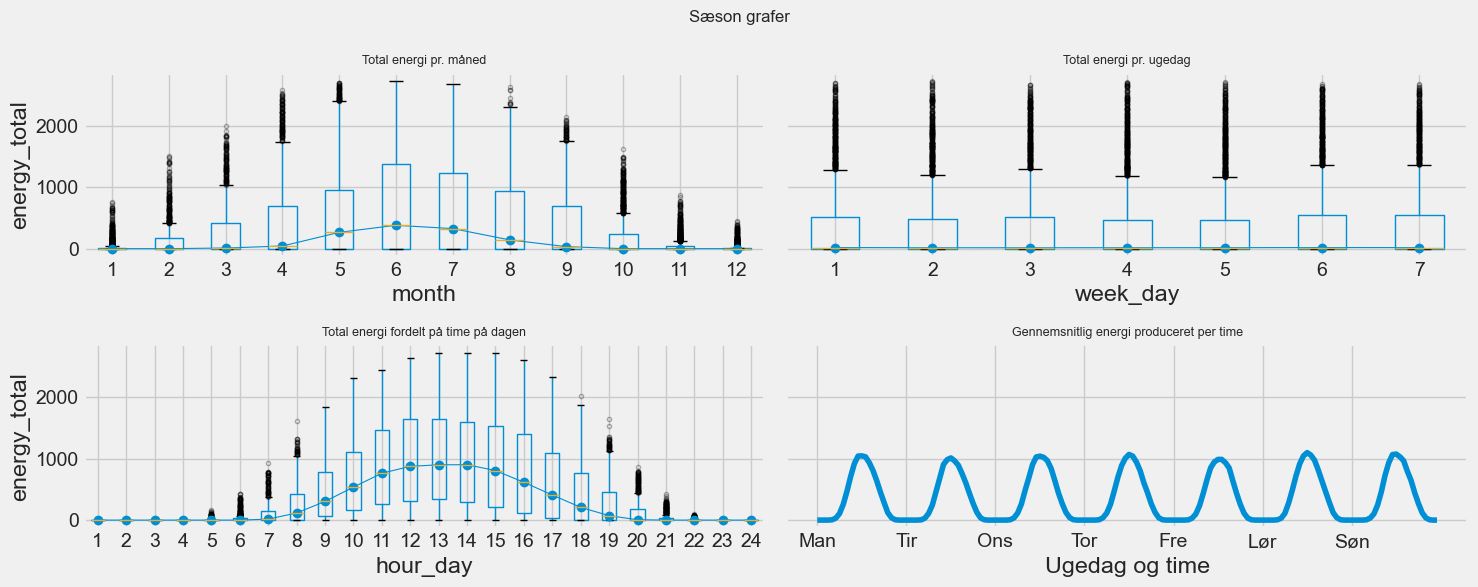

In [111]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
df['month'] = df.index.month
df.boxplot(column='energy_total', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('month')['energy_total'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('energy_total')
axs[0].set_title('Total energi pr. måned', fontsize=9)

# Users distribution by week day
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='energy_total', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('week_day')['energy_total'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('energy_total')
axs[1].set_title('Total energi pr. ugedag', fontsize=9)

# Users distribution by the hour of the day
df['hour_day'] = df.index.hour + 1
df.boxplot(column='energy_total', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('hour_day')['energy_total'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('energy_total')
axs[2].set_title('Total energi fordelt på time på dagen', fontsize=9)

# Users distribution by week day and hour of the day
mean_day_hour = df.groupby(["week_day", "hour_day"])["energy_total"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Gennemsnitlig energi produceret per time",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
    xlabel      = "Ugedag og time",
    ylabel      = "Energi i KWh"
)
axs[3].title.set_size(9)

fig.suptitle("Sæson grafer", fontsize=12)
fig.tight_layout()

ACF plot

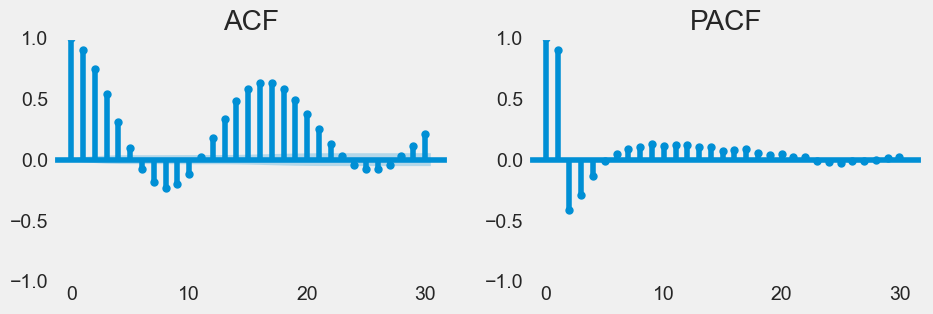

In [127]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
"""
Autokorrelation

This script generates an autocorrelation plot for the 'energy_total' column in the dataframe `df`.

Functions:
- plot_acf: Plots the autocorrelation function for a given time series.

Libraries:
- statsmodels.graphics.tsaplots: Provides functions to plot autocorrelation and partial autocorrelation functions.
- matplotlib.pyplot: Used for creating the figure and displaying the plot.

Steps:
1. Create a figure and axis object using `plt.subplots`.
2. Plot the autocorrelation function of the 'energy_total' column with 48 lags using `plot_acf`.
3. Display the plot using `plt.show`.

Parameters:
- df (DataFrame): A pandas DataFrame containing the time series data with a column named 'energy_total'.
"""
# Autocorrelation plot
# ==============================================================================
# Plot ACF and PACF for df_train
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# ACF plot
plot_acf(df['energy_total'], ax=ax[0], lags=30)
ax[0].set_title('ACF')

# PACF plot
plot_pacf(df['energy_total'], ax=ax[1], lags=30, method='ywm')
ax[1].set_title('PACF')

plt.show()

PACF

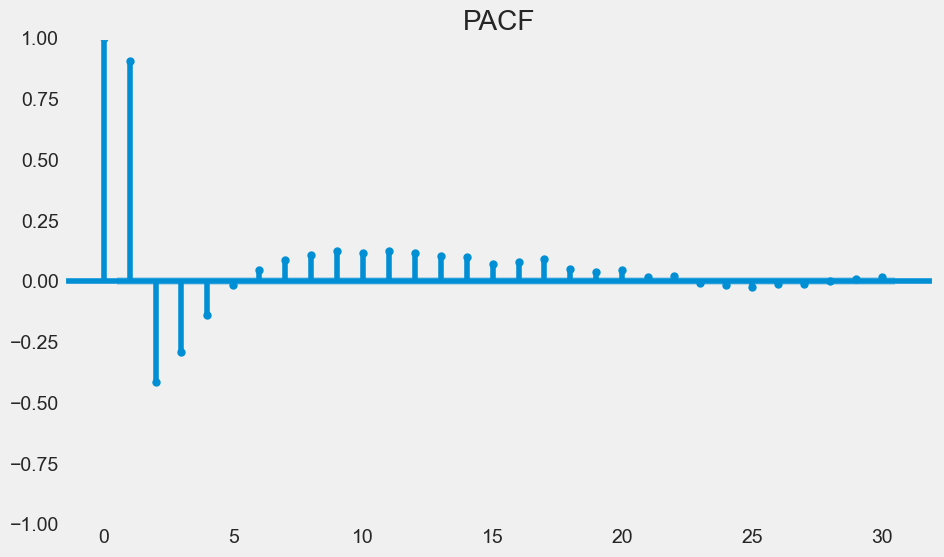

In [122]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['energy_total'], ax=ax, lags=30, method='ywm')
ax.set_title('PACF')
plt.show()

Now let's look at the periodogram:

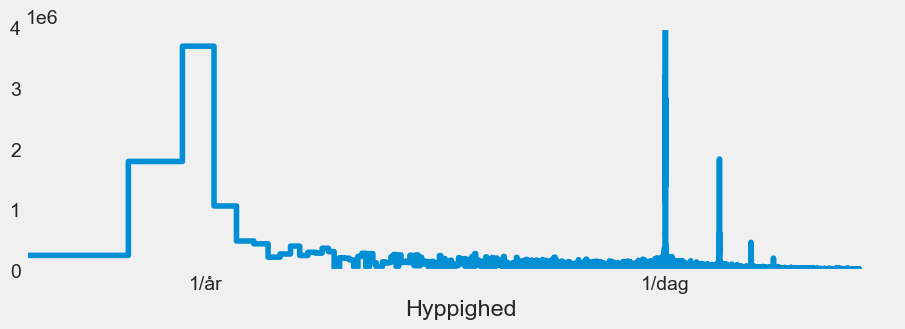

In [113]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 3)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
fft = tf.signal.rfft(df['energy_total'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['energy_total'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/år', '1/dag'])
_ = plt.xlabel('Hyppighed')

Et plot af de vigtigste features som følger samme distribution som energy_total

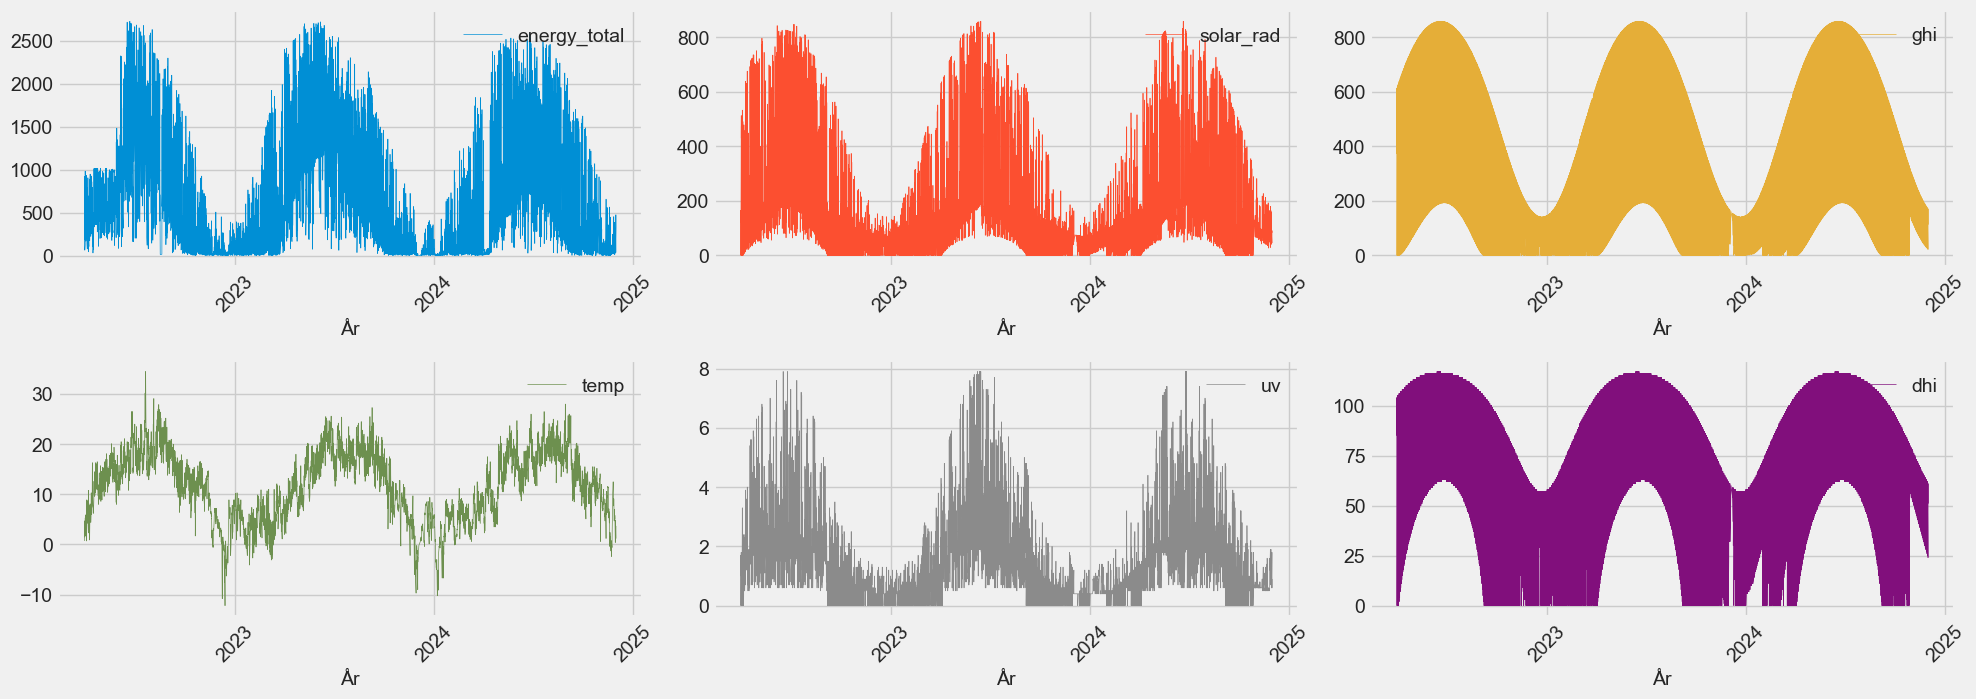

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Columns to plot
columns_to_plot = ['energy_total', 'solar_rad', 'ghi', 'temp', 'uv', 'dhi']

# Plot the selected columns
axes = df[columns_to_plot].plot(
    subplots=True,
    figsize=(20, 10),
    linewidth=0.5,
    layout=(3, 3),
    sharex=False,
    sharey=False
)

# Format x-axis ticks to show only years
for ax in axes.flatten():
    if ax:  # Check if the subplot exists
        ax.xaxis.set_major_locator(mdates.YearLocator())  # Place ticks at the start of each year
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to show only the year
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility
        ax.set_xlabel('År', fontsize=14)  # Set x-axis label to 'År'

# Add legends to each subplot
for ax, col in zip(axes.flatten(), columns_to_plot):
    if ax:  # Check if the subplot exists
        ax.legend([col], loc='upper right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


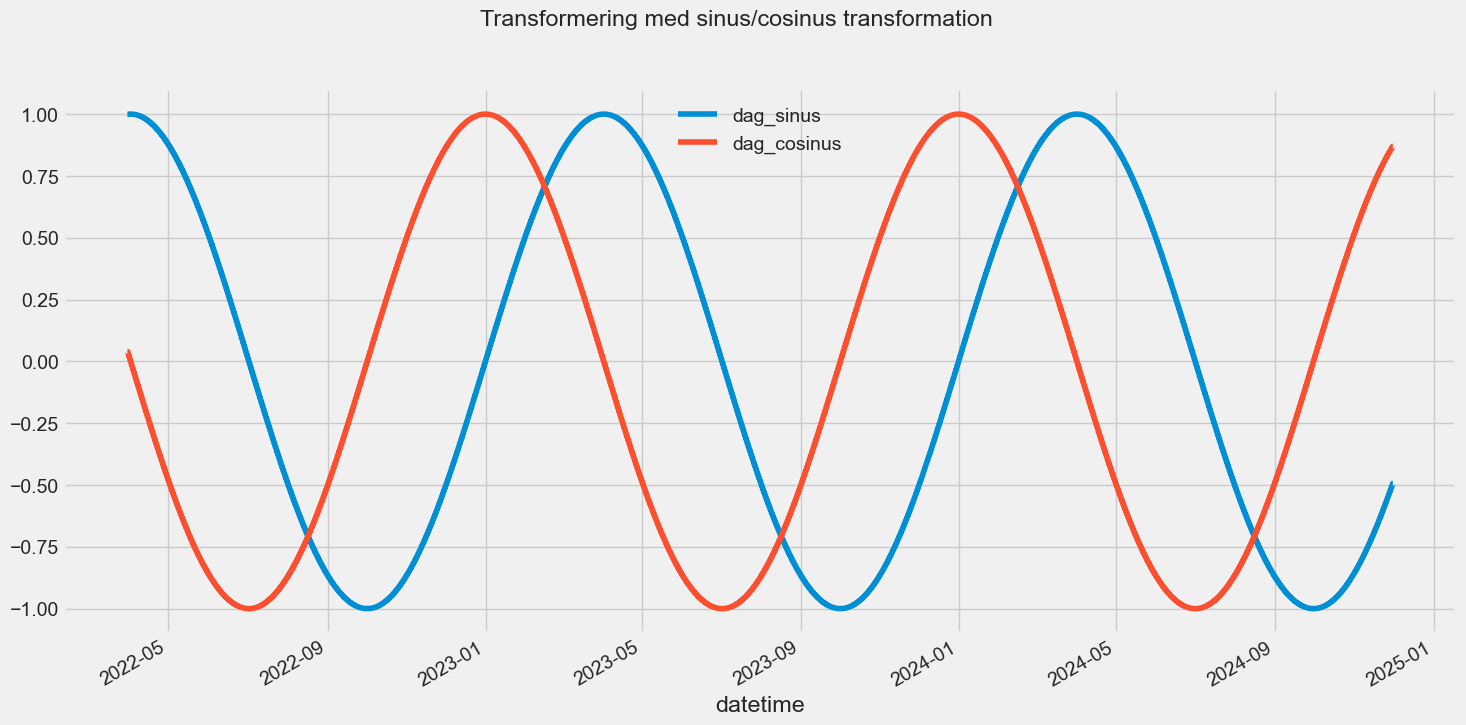

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
df[["day_sin", "day_cos"]].plot(ax=ax)
ax.legend(["dag_sinus", "dag_cosinus"])
plt.suptitle("Transformering med sinus/cosinus transformation")
plt.show()

Korrelations matrix

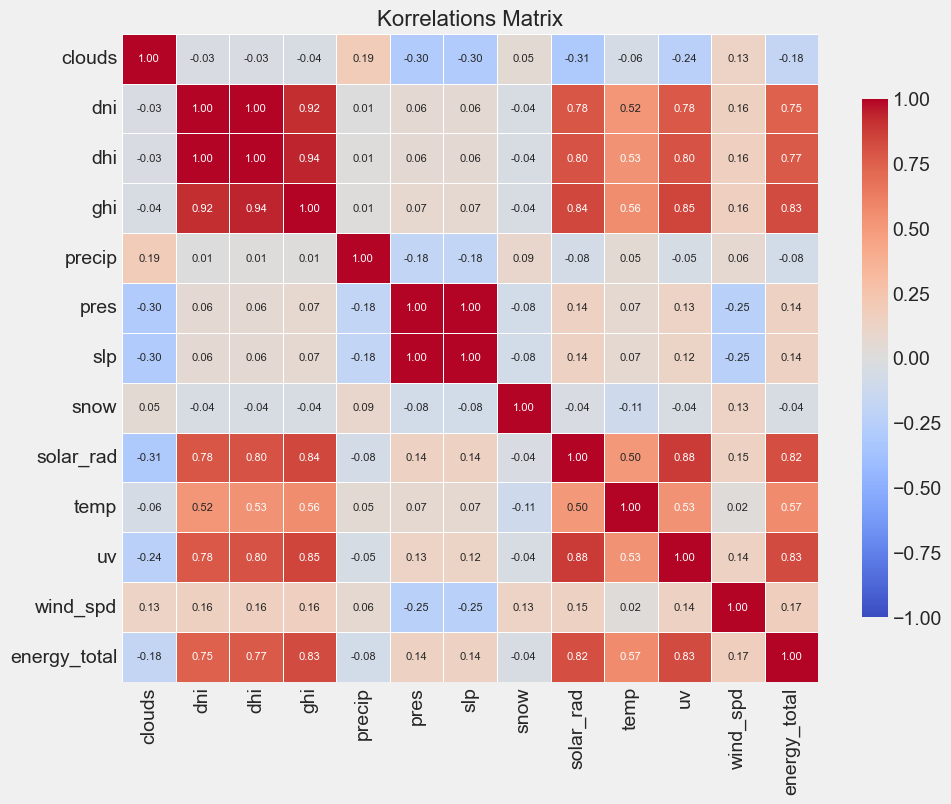

In [129]:
from seaborn import pairplot
import seaborn as sns
cor_columns = ['clouds', 'dni', 'dhi','ghi', 'precip', 'pres', 'slp',
       'snow', 'solar_rad', 'temp', 'uv', 'wind_spd', 'energy_total']
correlation_matrix = df[cor_columns].corr()

# Plot the heatmap with adjusted annotation font size
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show correlation values
    fmt=".2f",           # Format numbers to two decimals
    cmap="coolwarm",     # Diverging colormap
    vmin=-1, vmax=1,     # Set range for correlation coefficients
    linewidths=0.5,      # Add gridlines
    annot_kws={"size": 8},  # Adjust font size for annotations (smaller size)
    cbar_kws={"shrink": 0.8}  # Adjust color bar size
)

# Add a title
plt.title("Korrelations Matrix", fontsize=16)

# Display the plot
plt.show()

Removing any negative values and unnecassary columns

In [4]:
# Initially include all rows
df["Include"] = True

# Function to tag rows based on conditions
def tag_abnormal_values(df, condition, include_col='Include'):
    """
    Updates the Include column to False for rows that satisfy the given condition.

    :param df: The DataFrame to modify.
    :param condition: A condition (boolean array or series) for abnormal values.
    :param include_col: The column name to update for inclusion.
    :return: Modified DataFrame with updated Include column.
    """
    df.loc[condition, include_col] = False
    return df

# Define conditions for abnormality
conditions = [
    (df['energy_total'] < 1) | (df['energy_total'] > 2800)
]

# Exclude abnormal features
for condition in conditions:
    df = tag_abnormal_values(df, condition)
# Cut out all abnormal values
df = df[df.Include].drop(["Include"], axis=1)

#delete columns 'dhi', 'dni', 'precip', 'snow', 'wind_spd'
df = df.drop(['dhi', 'dni', 'precip', 'snow', 'wind_spd'], axis=1)

#extract the hour from the datetime column
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

#only keep rows where hour is between 8 and 18
df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
#delete three first rows
df = df.iloc[3:]

#drop hour column
df = df.drop(['hour'], axis=1)
df = df.drop(['hour_nr'], axis=1)
df = df.drop(['day_of_year'], axis=1)
df = df.drop(['month_nr'], axis=1)

#start the data from date 2022-03-30 08:00:00
df = df[df['datetime'] >= '2022-03-30 08:00:00']

#delete energy_total in df
#df = df.drop(columns=['datetime'], axis=1)

In [148]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,23510,2023-07-29 02:09:31.008081664,2022-03-25 09:00:00,2022-11-25 06:15:00,2023-07-29 04:30:00,2024-03-31 00:45:00,2024-12-01 22:00:00,NaN
clouds,23510.0,69.955211,0.0,48.0,85.0,100.0,100.0,34.605705
dhi,23510.0,39.246959,0.0,0.0,16.0,81.0,117.0,43.188081
dni,23510.0,325.175755,0.0,0.0,92.0,699.0,892.0,353.793497
ghi,23510.0,189.612973,0.0,0.0,10.0,342.0,859.0,260.071768
precip,23510.0,0.153871,0.0,0.0,0.0,0.0,26.5,0.586679
pres,23510.0,1009.851127,965.0,1003.0,1011.0,1017.0,1038.0,10.770999
slp,23510.0,1012.725904,967.0,1006.0,1014.0,1020.0,1041.0,10.814016
snow,23510.0,0.057848,0.0,0.0,0.0,0.0,37.5,0.834793
solar_rad,23510.0,114.696214,0.0,0.0,20.0,148.0,859.0,181.017828


Plotting distribution of the different features

In [5]:
columns_to_lag = ['clouds', 'ghi', 'pres', 'solar_rad', 'temp', 'uv']
# Define lags to create
lags = [10, 20, 30]

# Create lagged features
for lag in lags:
    for col in df[columns_to_lag]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Drop rows with NaN values caused by lagging
df = df.dropna()

print(df)

                 datetime  clouds  ghi  pres   slp  solar_rad  temp   uv  \
175   2022-04-01 16:00:00     100  226  1013  1016         91   3.9  0.6   
176   2022-04-01 17:00:00     100   87  1013  1016         54   2.9  0.6   
177   2022-04-01 18:00:00      97    0  1014  1017          0   1.8  0.0   
191   2022-04-02 08:00:00       0  393  1017  1020        393   2.3  2.3   
192   2022-04-02 09:00:00      54  509  1018  1021        453   2.5  2.6   
...                   ...     ...  ...   ...   ...        ...   ...  ...   
23475 2024-11-30 09:00:00      59   93  1024  1026         79   1.7  1.1   
23476 2024-11-30 10:00:00      78  148  1024  1026         91   2.4  0.9   
23477 2024-11-30 11:00:00      85  171  1024  1026         82   2.8  0.8   
23478 2024-11-30 12:00:00     100  159  1023  1025         75   3.2  0.6   
23479 2024-11-30 13:00:00      70  113  1023  1025         83   3.7  0.9   

       energy_total  month_sin  ...  pres_lag_20  solar_rad_lag_20  \
175          596.

Splitting into training, validation, and test sets 75%, 15%, and 10%

In [6]:
df.reset_index(drop=True, inplace=True)  # Use RangeIndex

train_end = int(0.80 * len(df))
val_end = train_end + int(0.10 * len(df))

df_train = df.iloc[:train_end, :].copy()
df_val = df.iloc[train_end:val_end, :].copy()
df_test = df.iloc[val_end:, :].copy()

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 7786
Validation size: 973
Test size: 974


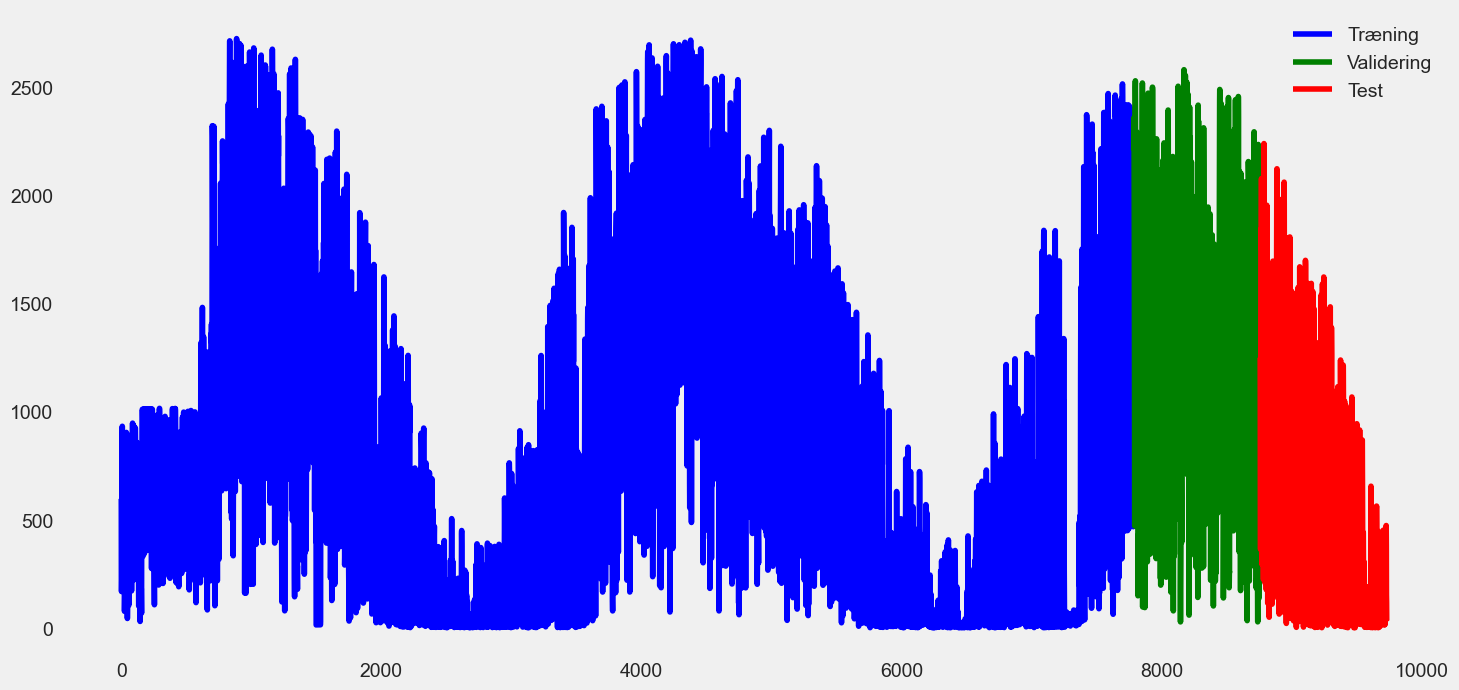

In [137]:
#plot the different datasets with energy_total and different colors for each dataset
fig, ax = plt.subplots(figsize=(16, 8))
df_train['energy_total'].plot(ax=ax, color='blue', label='Træning')
df_val['energy_total'].plot(ax=ax, color='green', label='Validering')
df_test['energy_total'].plot(ax=ax, color='red', label='Test')
plt.legend()
plt.show()

Standardizing the columns to the same scale, but not the target column

In [7]:
# Calculate mean and standard deviation for all features except 'energy_total'
features_to_scale = ['clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv',
       'clouds_lag_10', 'ghi_lag_10',
       'pres_lag_10', 'solar_rad_lag_10', 'temp_lag_10', 'uv_lag_10',
       'clouds_lag_20', 'ghi_lag_20', 'pres_lag_20', 'solar_rad_lag_20',
       'temp_lag_20', 'uv_lag_20', 'clouds_lag_30', 'ghi_lag_30',
       'pres_lag_30', 'solar_rad_lag_30', 'temp_lag_30', 'uv_lag_30']

train_mean = df_train[features_to_scale].mean()
train_std = df_train[features_to_scale].std()

# Scale the selected features
df_train[features_to_scale] = (df_train[features_to_scale] - train_mean) / train_std
df_val[features_to_scale] = (df_val[features_to_scale] - train_mean) / train_std
df_test[features_to_scale] = (df_test[features_to_scale] - train_mean) / train_std
df[features_to_scale] = (df[features_to_scale] - train_mean) / train_std

In [3]:
#define that exog_features are all columns except energy_total and datetime
exog_features = [col for col in df.columns if col not in ['energy_total', 'datetime']]

NameError: name 'df' is not defined

XGBoosting model

In [2]:
from skforecast.preprocessing import RollingFeatures
from xgboost import XGBRegressor
# Create forecaster
# ==============================================================================
forecaster_xgb = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True, tree_method='hist'),
                lags            = 10
             )

NameError: name 'ForecasterRecursive' is not defined

In [75]:
forecaster_xgb

=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: None 
Window size: 10 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': None, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': None, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None,
    'missing': nan, 'monotone_constraints': None, 'multi_strategy': None,
    'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None,
    'random_state': 15926, 'reg_alpha': None, 'reg_lambda': None,
    'sampling_method': None, 'scale_pos_weight': None, 'subsample': None,
    'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-01-05 12:07:31 
Last fit date: None 
Skforecast version: 0.14.0 
Python version: 3.11.9 
Forecaster id: None

In [10]:
# Folds used for the hyperparameter search and backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(df_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 10,
                    initial_train_size = len(df[:val_end]),
                    refit              = True
                 )

In [11]:
# Lags used as predictors
lags_grid = [[1, 2, 3,10]]


# Enhanced Regressor hyperparameters search space
def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 16, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, step=0.001),
        'subsample': trial.suggest_float('subsample', 0.5, 1, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.05),
        'gamma': trial.suggest_float('gamma', 0, 10, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
        'lags': trial.suggest_categorical('lags', lags_grid),
    }
    return search_space

# Perform the Bayesian search
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster_xgb,
    y=df.loc[:val_end, 'energy_total'],
    exog=df.loc[:val_end, exog_features],
    cv=cv_search,
    search_space=search_space,
    metric='mean_absolute_error',
    n_trials=100,  # Increased number of trials for more exhaustive search
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=True,  # Set to True to monitor progress
    show_progress=True
)

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 10] 
  Parameters: {'n_estimators': 1400, 'max_depth': 6, 'learning_rate': 0.003, 'subsample': 0.55, 'colsample_bytree': 1.0, 'gamma': 3.8000000000000003, 'reg_alpha': 0.8, 'reg_lambda': 3.6, 'min_child_weight': 2}
  One-step-ahead metric: 259.09827307442225


In [12]:
forecaster_xgb

=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [ 1  2  3 10] 
Window features: None 
Window size: 10 
Exogenous included: True 
Exogenous names: 
    clouds, ghi, pres, slp, solar_rad, temp, uv, month_sin, month_cos, day_sin,
    day_cos, hour_sin, hour_cos, sine_elevation, cosine_elevation, sine_azimuth,
    cosine_azimuth, clouds_lag_10, ghi_lag_10, pres_lag_10, solar_rad_lag_10,
    temp_lag_10, uv_lag_10, clouds_lag_20, ghi_lag_20, pres_lag_20,
    solar_rad_lag_20, temp_lag_20, uv_lag_20, clouds_lag_30, ghi_lag_30,
    pres_lag_30, solar_rad_lag_30, temp_lag_30, uv_lag_30 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 8759] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': 3.8000000000000003, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': 0.003, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 2, 'missing':
    nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators':
    1400, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 15926,
    'reg_alpha': 0.8, 'reg_lambda': 3.6, 'sampling_method': None,
    'scale_pos_weight': None, 'subsample': 0.55, 'tree_method': 'hist',
    'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-01-06 11:36:48 
Last fit date: 2025-01-06 11:41:12 
Skforecast version: 0.14.0 
Python version: 3.11.9 
Forecaster id: None

In [13]:
results_search.head(4)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_child_weight
0,"[1, 2, 3, 10]","{'n_estimators': 1400, 'max_depth': 6, 'learni...",259.098273,1400.0,6.0,0.003,0.55,1.00,3.8,0.8,3.6,2.0
1,"[1, 2, 3, 10]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",261.953247,1000.0,3.0,0.016,0.55,0.75,5.2,0.4,6.2,2.0
2,"[1, 2, 3, 10]","{'n_estimators': 200, 'max_depth': 3, 'learnin...",262.294236,200.0,3.0,0.083,0.50,0.95,0.7,0.9,5.8,5.0
3,"[1, 2, 3, 10]","{'n_estimators': 200, 'max_depth': 4, 'learnin...",262.635246,200.0,4.0,0.108,0.50,1.00,1.9,9.9,5.3,6.0


In [ ]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_xgboost, predictions_xgb = backtesting_forecaster(
    forecaster    = forecaster_xgb,
    y             = df['energy_total'],
    exog          = df[exog_features],
    cv            = cv_backtesting,
    metric        = 'mean_absolute_percentage_error',
    n_jobs        = 'auto',
    verbose       = False,
)
metric_xgboost

NameError: name 'backtesting_forecaster' is not defined

,mean_absolute_percentage_error
0,2.991639


Extracting all the exogenous features

In [105]:
# Extract feature importance
# ==============================================================================
importance = forecaster_xgb.get_feature_importances()
importance.head(10)

,feature,importance
0,lag_1,0.490646
5,ghi,0.049708
18,cosine_elevation,0.048615
17,sine_elevation,0.044223
8,solar_rad,0.042545
10,uv,0.038299
16,hour_cos,0.028084
15,hour_sin,0.016685
3,lag_10,0.015608
19,sine_azimuth,0.015341


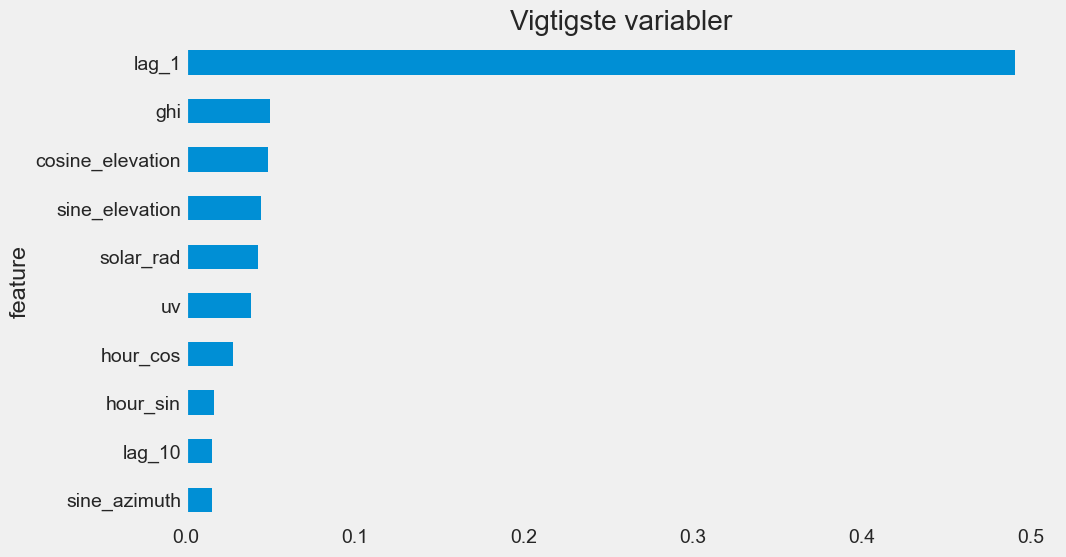

In [139]:
# Plot feature importance
importance = forecaster_xgb.get_feature_importances()
importance.columns = ['feature', 'importance']  # Ensure correct column names
importance = importance.sort_values('importance', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
importance.tail(10).set_index('feature')['importance'].plot(kind='barh', ax=ax)
ax.set_title('Vigtigste variabler')
plt.show()

In [48]:
# Create and train forecaster
# ==============================================================================
forecaster_rf = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10
             )

In [49]:
from skforecast.model_selection import grid_search_forecaster
# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(df_train)),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
# Lags used as predictors
lags_grid = {
    'lags 2': [1, 2,3, 10]
}

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [250, 300, 400],
    'max_depth': [3, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'random_state': [123]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster_rf,
                     y=df.loc[:val_end, 'energy_total'],
                     exog=df.loc[:val_end, exog_features],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_absolute_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/81 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 10] 
  Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300, 'random_state': 123}
  Backtesting metric: 366.5680222573128


In [50]:
# Search results
# ==============================================================================
results_grid.head(4)

,lags,lags_label,params,mean_absolute_error,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,random_state
0,"[1, 2, 3, 10]",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",366.568022,10,sqrt,4,5,300,123
1,"[1, 2, 3, 10]",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",366.568022,10,sqrt,4,2,300,123
2,"[1, 2, 3, 10]",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",366.609432,10,sqrt,4,5,250,123
3,"[1, 2, 3, 10]",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",366.609432,10,sqrt,4,2,250,123


In [52]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor_rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=123, max_features='sqrt', min_samples_leaf=4, min_samples_split=5)
forecaster_rf = ForecasterRecursive(
                 regressor = regressor_rf,
                 lags      = [1, 2,3, 10]
             )
forecaster_rf.fit(y=df.loc[:val_end, 'energy_total'], exog=df.loc[:val_end, exog_features])

In [53]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_rf, predictions_rf = backtesting_forecaster(
                            forecaster    = forecaster_rf,
                            y             = df['energy_total'],
                            exog          = df[exog_features],
                            cv            = cv_backtesting,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                       )
display(metric_rf)
predictions_rf.head()

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\_validation.py:185: LongTrainingWarning:

The forecaster will be fit 98 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/98 [00:00<?, ?it/s]

,mean_absolute_error
0,202.968108


,pred
8759,1406.435768
8760,1074.331488
8761,762.934923
8762,507.828754
8763,703.658184


In [54]:
# Extract feature importance
# ==============================================================================
importance_rf = forecaster_rf.get_feature_importances()
importance_rf.head(10)

,feature,importance
0,lag_1,0.259541
1,lag_2,0.119156
11,uv,0.089567
9,solar_rad,0.069616
19,cosine_elevation,0.055116
18,sine_elevation,0.054767
5,dhi,0.049922
3,lag_10,0.046762
6,ghi,0.043328
2,lag_3,0.034164


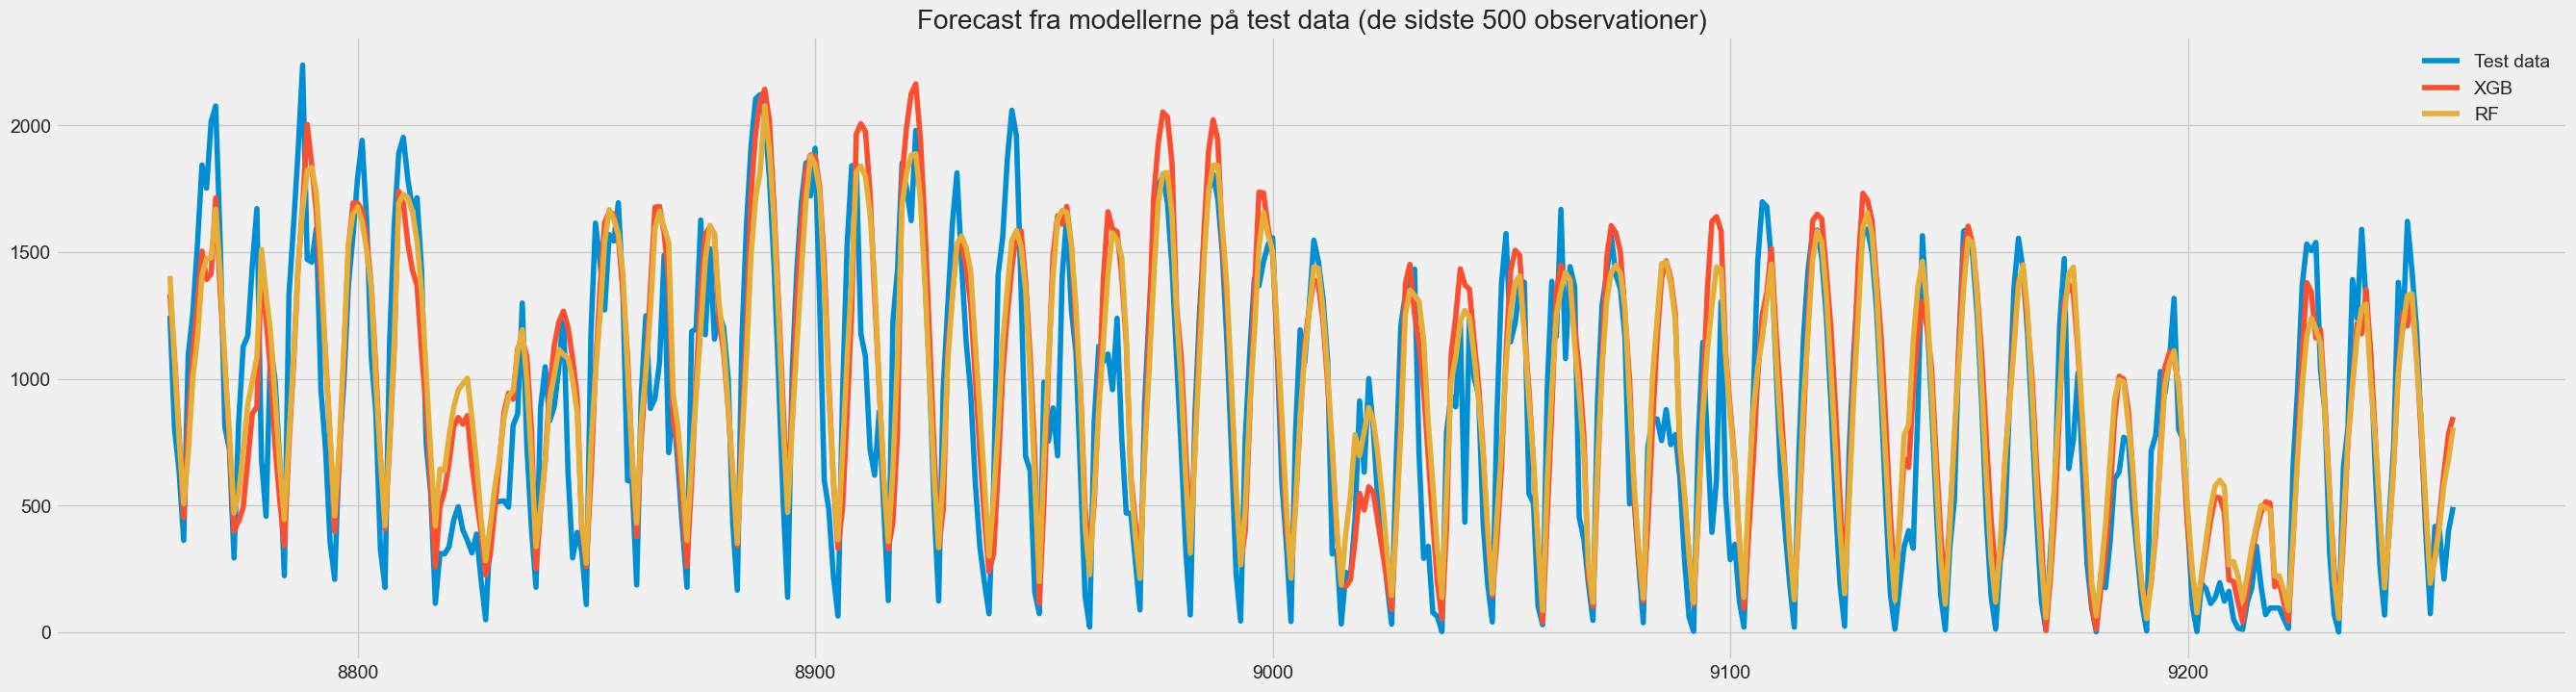

In [98]:
# Plot the last 100 observations
fig, ax = plt.subplots(figsize=(30, 8))
df['energy_total'].loc[val_end:].head(500).plot(ax=ax, label='test')
predictions_xgb.head(500).plot(ax=ax, label='XGBoost')
predictions_rf.head(500).plot(ax=ax, label='Random Forest')
ax.set_title('Forecast fra modellerne på test data (de sidste 500 observationer)')
ax.legend()
ax.legend(['Test data', 'XGB', 'RF'])
plt.show()

In [80]:
#make one new data set with only the predictions on the test set and the test set for both models and save it as a excel file
df_test['energy_total_xgb'] = predictions_xgb
df_test['energy_total_rf'] = predictions_rf
df_test.to_excel('C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/data_final_predictions.xlsx')

In [63]:
from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
# ==============================================================================
mape_xgb = mean_absolute_percentage_error(df_test['energy_total'], predictions_xgb)
mape_rf = mean_absolute_percentage_error(df_test['energy_total'], predictions_rf)

print(f"MAPE XGBoost: {mape_xgb}")
print(f"MAPE Random Forest: {mape_rf}")

MAPE XGBoost: 2.654261556505064
MAPE Random Forest: 2.566566511145496


In [64]:
#calculate the R2 score
from sklearn.metrics import r2_score
r2_xgb = r2_score(df_test['energy_total'], predictions_xgb)
r2_rf = r2_score(df_test['energy_total'], predictions_rf)

print(f"R2 XGBoost: {r2_xgb}")
print(f"R2 Random Forest: {r2_rf}")

R2 XGBoost: 0.7582983798894171
R2 Random Forest: 0.7609305786127759


In [20]:
#calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(df_test['energy_total'], predictions_xgb)
#mae_rf = mean_absolute_error(df_test['energy_total'], predictions_rf)

print(f"MAE XGBoost: {mae_xgb}")
#print(f"MAE Random Forest: {mae_rf}")

MAE XGBoost: 204.86417656023156
